# Градиентный спуск.

В этом задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

In [1]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [2]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        loss = ((X.dot(w) - y) ** 2).sum() / y.shape[0]
        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        gradient = 2*X.T.dot(X.dot(w) - y) / y.shape[0]
        return gradient

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать
траекторию спуска (список из новых значений весов на каждом шаге)

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = [w_init]
    for n in range(n_iterations):
      w.append(w[-1] - lr * loss.calc_grad(X, y, w[-1]))
    return w

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

lr = 0.0001


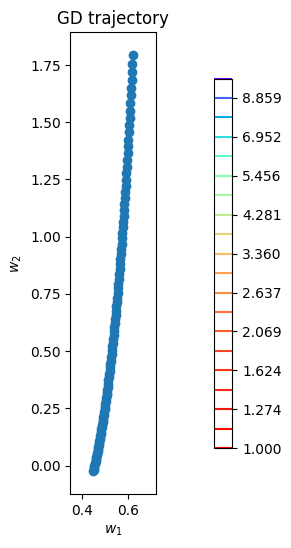

lr = 0.001


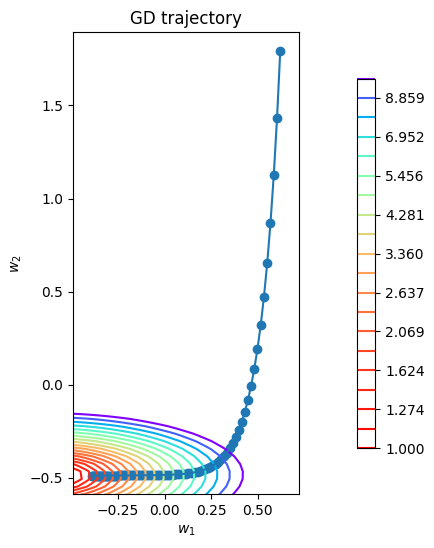

lr = 0.005


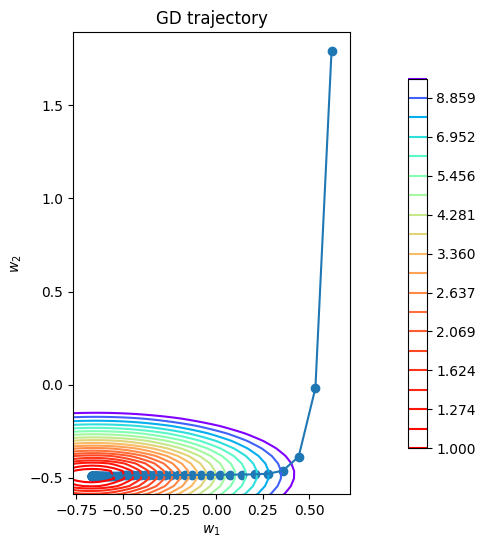

lr = 0.01


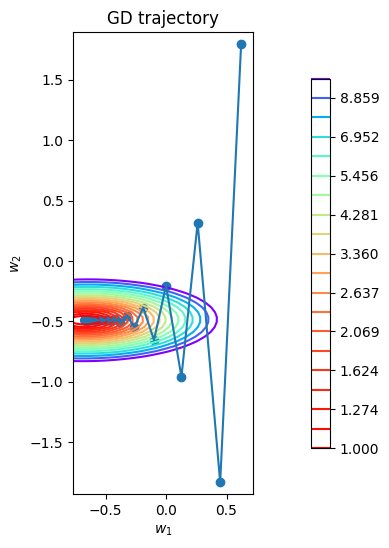

lr = 0.1


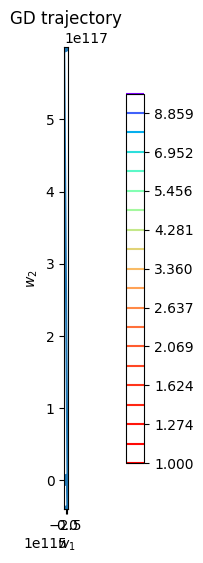

In [9]:
lr_list = [0.0001, 0.001, 0.005, 0.01, 0.1]
for lr in lr_list:
  print('lr =', lr)
  plot_gd(gradient_descent(w_init, X, y, loss, lr, 100), X, y, loss)

Видно, что слишком маленькие значение шага на первых двух графиках не дают функции дойти до минимума.Третий график наиболее оптимальный, функция сходится в минимум ровно и четко. На четвертом графике функция ведет себя нестабильно, перескакивая нужные уровни, но в конце все равно оказывается в минимуме. На пятом графике функция расходится, проанализировать становится сложно.

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = [w_init]
    for n in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      y_batch = y[batch_indices]
      w.append(w[-1] - lr * loss.calc_grad(batch, y_batch, w[-1]))
    return w

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

batch = 1 lr = 0.0001


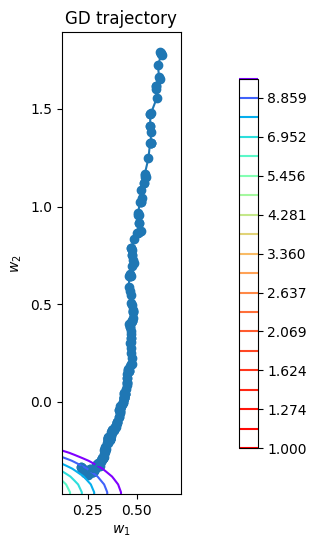

batch = 1 lr = 0.001


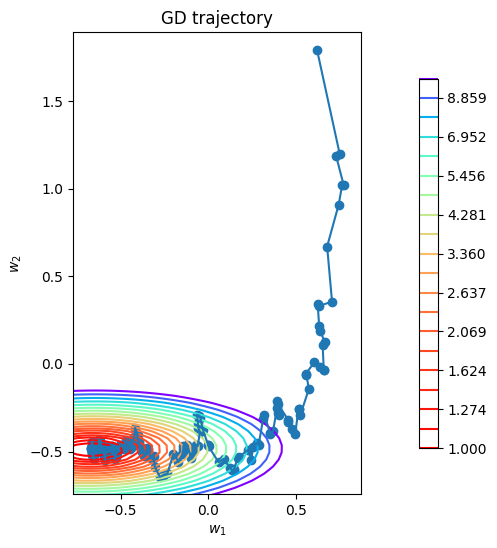

batch = 1 lr = 0.005


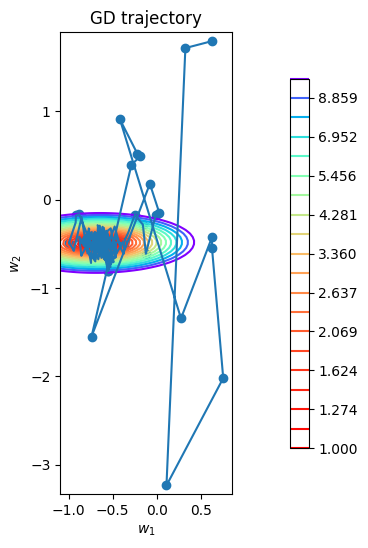

batch = 1 lr = 0.01


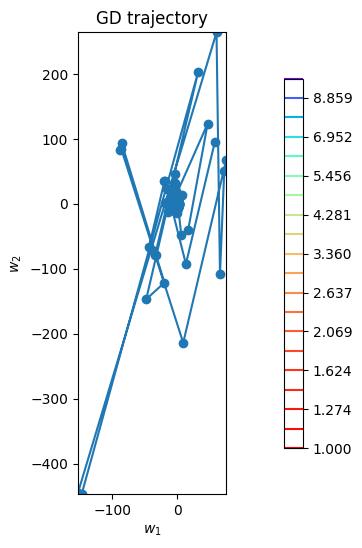

batch = 1 lr = 0.1


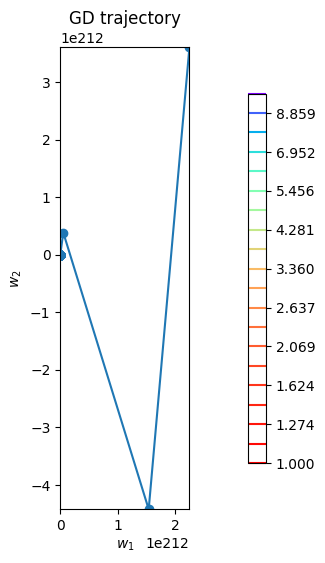

batch = 10 lr = 0.0001


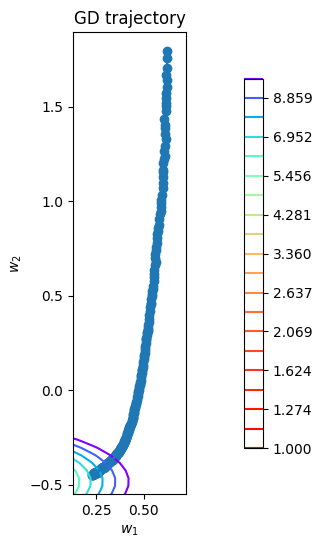

batch = 10 lr = 0.001


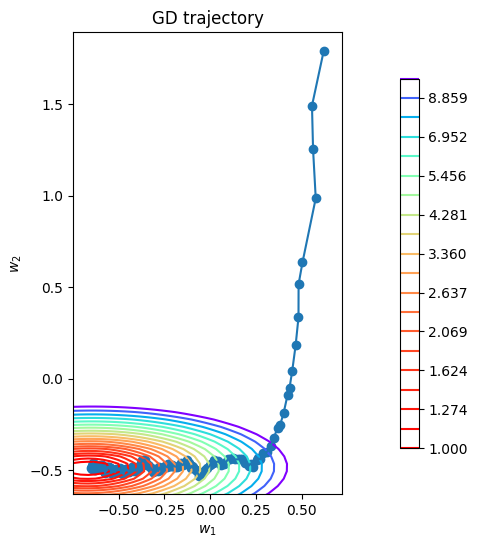

batch = 10 lr = 0.005


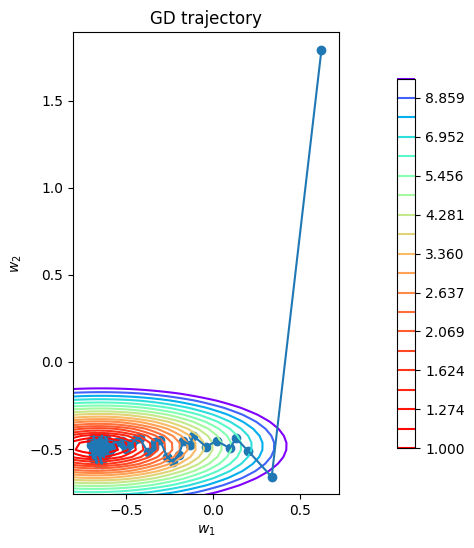

batch = 10 lr = 0.01


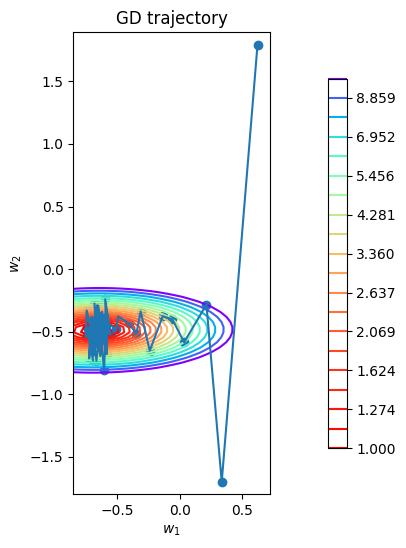

batch = 10 lr = 0.1


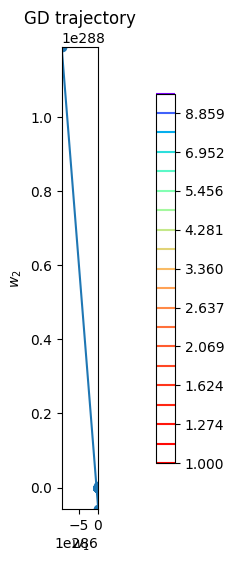

batch = 50 lr = 0.0001


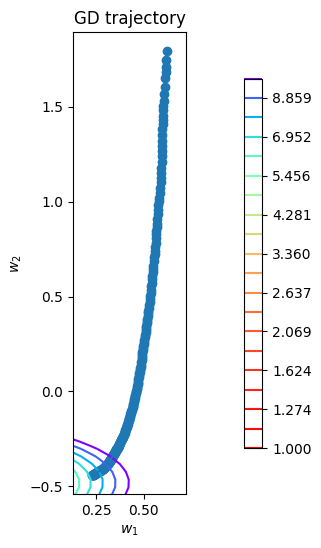

batch = 50 lr = 0.001


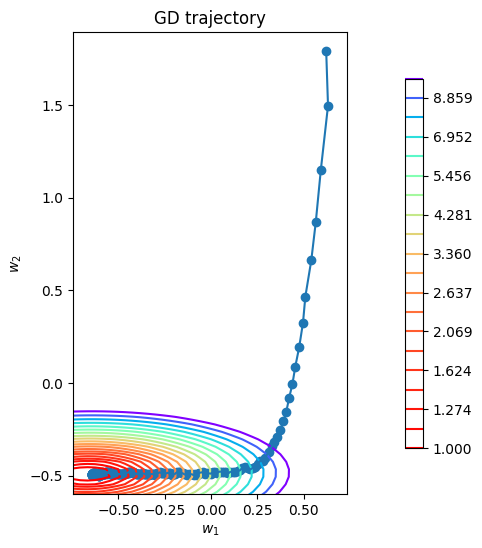

batch = 50 lr = 0.005


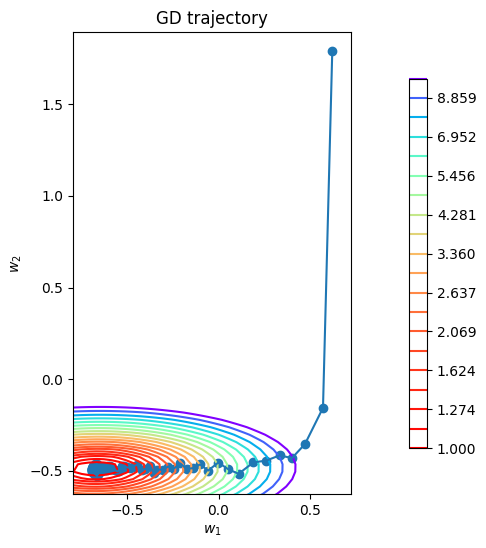

batch = 50 lr = 0.01


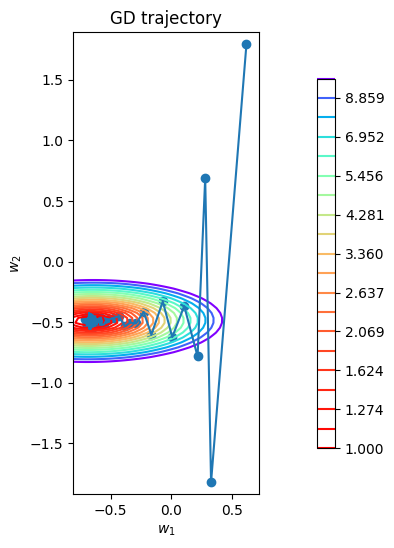

batch = 50 lr = 0.1


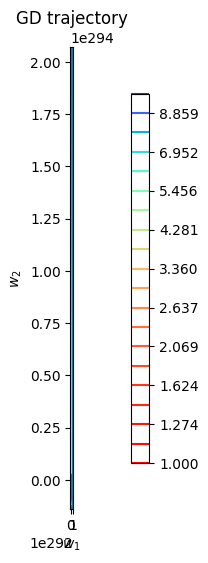

batch = 100 lr = 0.0001


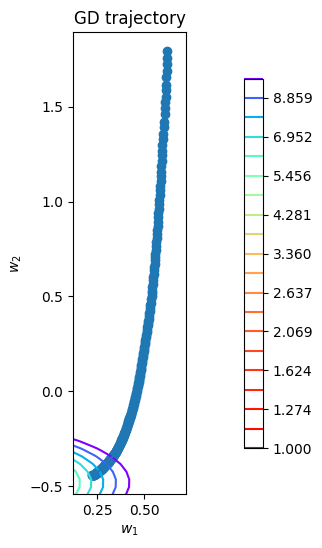

batch = 100 lr = 0.001


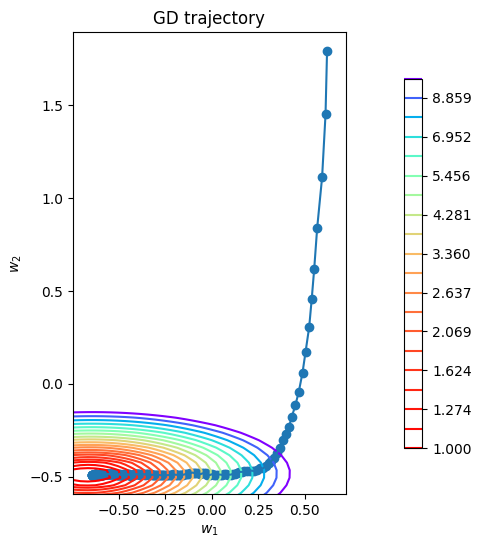

batch = 100 lr = 0.005


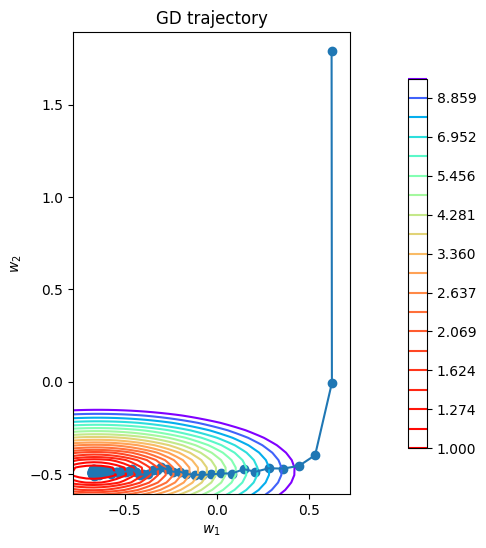

batch = 100 lr = 0.01


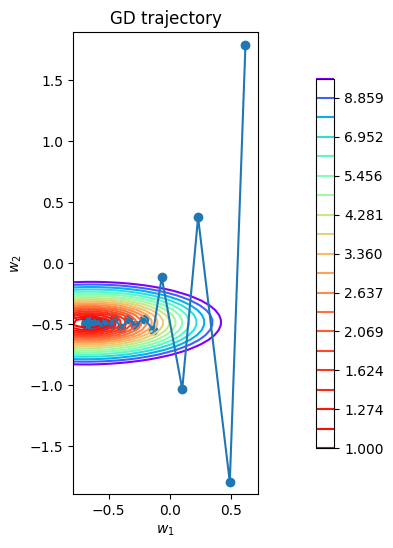

batch = 100 lr = 0.1


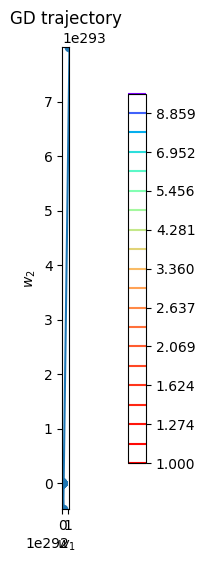

In [11]:
batch_sizes = [1, 10, 50, 100]
lr_list = [0.0001, 0.001, 0.005, 0.01, 0.1]
for batch_item in batch_sizes:
  for lr in lr_list:
    print('batch =', batch_item, 'lr =', lr)
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, lr, batch_item, 250), X, y, loss)

Заметно, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = [w_init]
    for n in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      y_batch = y[batch_indices]
      w.append(w[-1] - lr * (1 / (1 + n))**p * loss.calc_grad(batch, y_batch, w[-1]))
    return w

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

p = 0.1


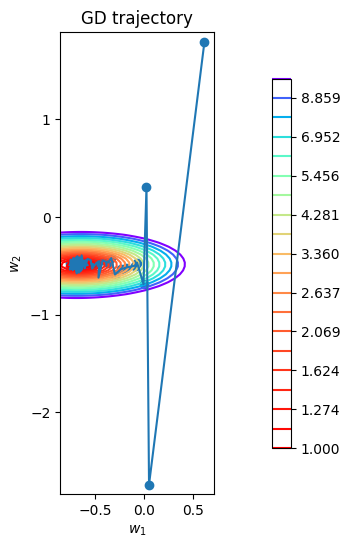

p = 0.25


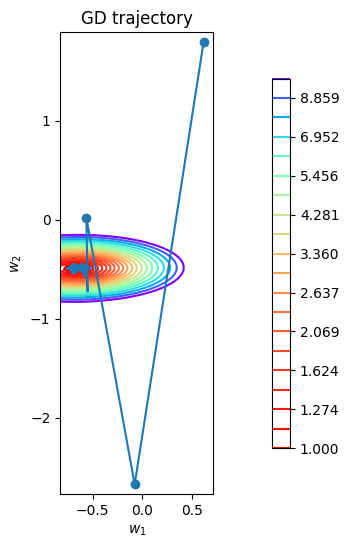

p = 0.5


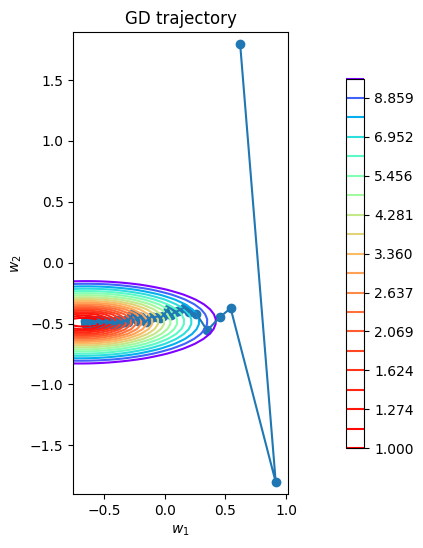

p = 0.7


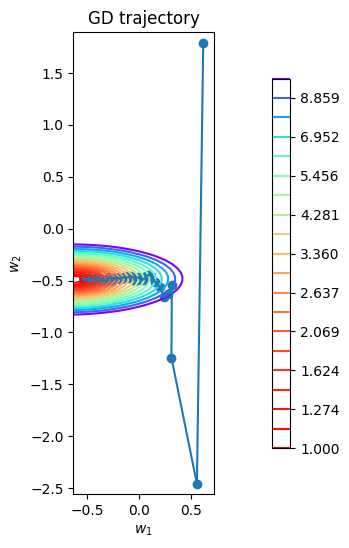

p = 1


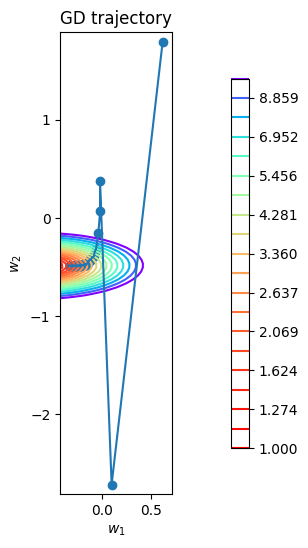

p = 1.5


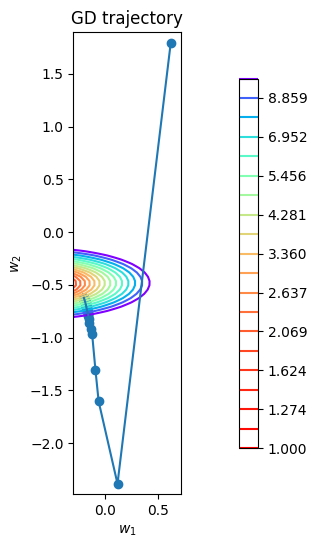

p = 2


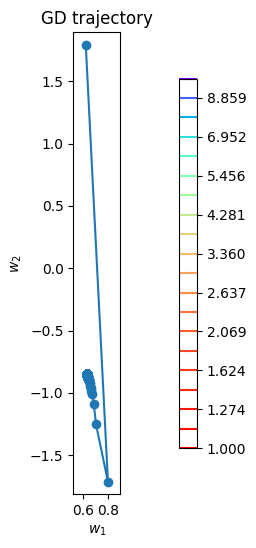

In [13]:
p_list = [0.1, 0.25, 0.5, 0.7, 1, 1.5, 2]
for p in p_list:
  print('p =', p)
  plot_gd(stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p, 250), X, y, loss)

При увеличении p шаги уменьшаются быстрее, и при больших значениях p градиентный спуск может не дойти до минимума. В данном случае оптимальное значение около 0.5, именно в этом случае функция ближе всего к минимуму

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

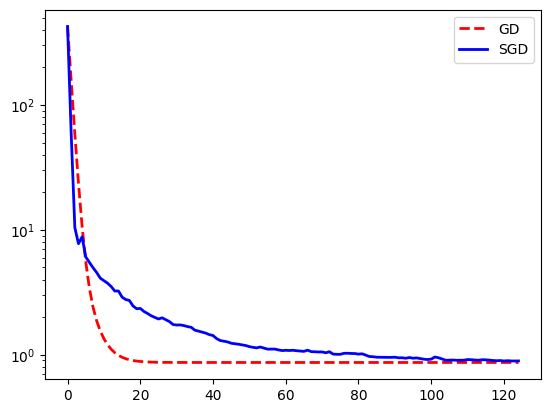

In [14]:
loss = MSELoss()
loss_list_GD = []
loss_list_SGD = []

n_iterations = 125

w_GD = gradient_descent(w_init, X, y, loss, lr=0.01, n_iterations=n_iterations)
w_SGD = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p=0.5, n_iterations=n_iterations)

for i in range(n_iterations):
  loss_GD = loss.calc_loss(X, y, w_GD[i])
  loss_list_GD.append(loss_GD)
  loss_SGD = loss.calc_loss(X, y, w_SGD[i])
  loss_list_SGD.append(loss_SGD)

plt.plot(range(n_iterations), loss_list_GD, linestyle='--', linewidth=2, color='red')
plt.plot(range(n_iterations), loss_list_SGD, linestyle='-', linewidth=2, color='blue')

plt.yscale('log')
plt.legend(['GD', 'SGD'])
plt.show()

Видно, что SGD нужно больше шагов для достижения оптимума, а также эти шаги менее стабильные. Однако для каждого шана SGD нужно гораздо меньше времени, по сравнению с обычным GD

### Алгоритм имитации отжига

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать его на практике.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE.

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [15]:
def annealing_alg(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                  loss: BaseLoss, q0: float, n_iterations: int = 100000):
    """
    Реализация алгоритма имитации отжига для оптимизации функции потерь.

    :param w_init: np.ndarray размера (n_features,) — начальное значение вектора весов.
    :param X: np.ndarray размера (n_objects, n_features) — матрица объекты-признаки.
    :param y: np.ndarray размера (n_objects,) — вектор правильных ответов.
    :param loss: Объект подкласса BaseLoss, который умеет считать значение функции потерь
                 при помощи метода loss.calc_loss(X, y, w).
    :param q0: float — начальное значение параметра температуры (влияет на вероятность
                 принятия худших решений).
    :param n_iterations: int — количество итераций алгоритма (по умолчанию 100000).
    :return: Список из объектов np.ndarray размера (n_features,) — история весов на каждом шаге.
    """
    lst = [w_init]
    for i in range(1, n_iterations + 1):
        # Уменьшение температуры по логарифмическому закону
        q = q0 / np.log(1 + i)
        # Генерация нового решения с использованием распределения Стьюдента
        new_w = lst[-1] + q * np.random.standard_t(3, size=lst[-1].shape)
        # Разница значений функции потерь между новым и текущим решением
        delta_F = loss.calc_loss(X, y, new_w) - loss.calc_loss(X, y, lst[-1])
        # Если новое решение лучше, принимаем его
        if delta_F <= 0:
            lst.append(new_w)
        # Иначе принимаем его с вероятностью exp(-delta_F / q)
        elif np.random.binomial(1, np.exp(-delta_F / q)):
            lst.append(new_w)
    return lst

In [16]:
w_list = annealing_alg(w_init, X, y, loss, 50, 8000)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
4.049169007738279


In [17]:
def plot_annealing(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Визуализация траектории алгоритма имитации отжига в пространстве весов.

    :param w_list: Список из объектов np.ndarray размера (n_features,) — история весов на каждом шаге.
    :param X: np.ndarray размера (n_objects, n_features) — матрица объекты-признаки.
    :param y: np.ndarray размера (n_objects,) — вектор правильных ответов.
    :param loss: Объект подкласса BaseLoss, который умеет считать значение функции потерь
                 при помощи метода loss.calc_loss(X, y, w).
    """
    w_list = np.array(w_list)
    # Создание сетки для визуализации уровней функции потерь
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    # Вычисление значений функции потерь для каждой точки сетки
    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    # Настройка графика
    plt.figure(figsize=(15, 15))
    plt.title("Annealing trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1,
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # Визуализация уровней функции потерь
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8)

    # Визуализация траектории алгоритма
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

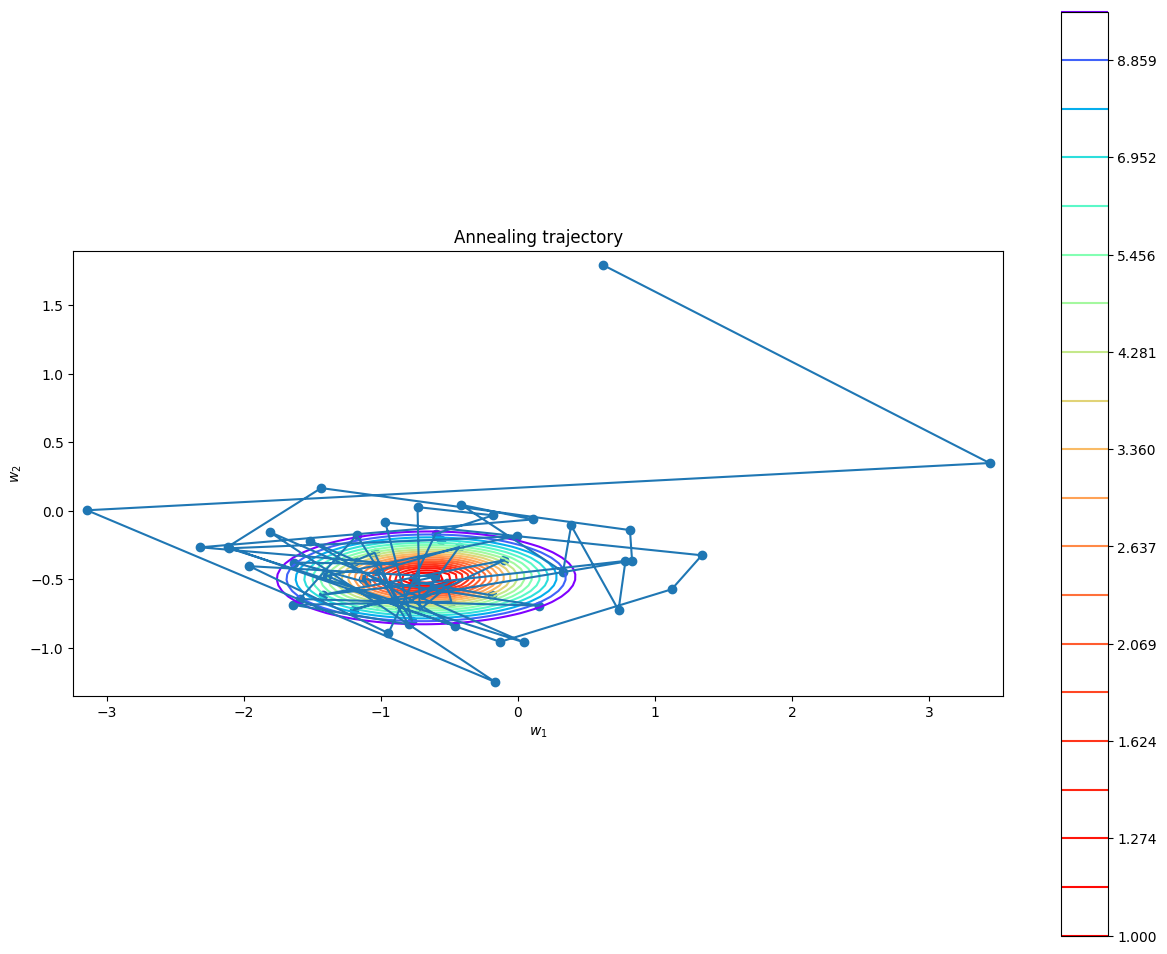

In [18]:
plot_annealing(w_list, X, y, loss)

Сравнение с градиентным спуском
1. Градиентный спуск (GD/SGD):

* Градиентный спуск движется в направлении антиградиента, что гарантирует сходимость к локальному минимуму.

* Траектория GD/SGD обычно более гладкая, но может застрять в локальных минимумах.

2.  Имитация отжига (SA):

* SA позволяет "прыгать" между точками, что помогает избежать локальных минимумов.

* Траектория SA более случайная, но при правильном выборе параметров (температура, охлаждение) может найти глобальный минимум.

Как можно заметить по визуализации, алгоритм имитации отжига не плавно идёт к минимуму, а резко скачет между точками. Финальный loss оказался чуть больше, чем при градиентном спуске.

## Часть 2. Линейная регрессия

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету,

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [19]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = np.arange(X.shape[1])
        w_list = gradient_descent(self.w, X, y, self.loss, self.lr, n_iterations=1000)
        self.w = w_list[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return np.dot(X, self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [20]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [21]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
print(X_raw.head())
X_raw = X_raw[~X_raw[25].isna()].reset_index()

   0      1            2    3    4     5            6    7      8     9   ...  \
0   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
1   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
2   1    NaN  alfa-romero  gas  std   two    hatchback  rwd  front  94.5  ...   
3   2  164.0         audi  gas  std  four        sedan  fwd  front  99.8  ...   
4   2  164.0         audi  gas  std  four        sedan  4wd  front  99.4  ...   

    16    17    18    19    20     21      22  23  24       25  
0  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  13495.0  
1  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  16500.0  
2  152  mpfi  2.68  3.47   9.0  154.0  5000.0  19  26  16500.0  
3  109  mpfi  3.19  3.40  10.0  102.0  5500.0  24  30  13950.0  
4  136  mpfi  3.19  3.40   8.0  115.0  5500.0  18  22  17450.0  

[5 rows x 26 columns]


In [22]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [23]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       164 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       199 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      197 non-null    float64
 20  19      197 non-null    float64
 21  20      201 non-null    float64
 22  21

In [24]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Преобразуем все названия столбцов в строки
X_raw.columns = X_raw.columns.astype(str)

# Определяем категориальные признаки
cat_features = (X_raw.dtypes == 'object').values

# Заполняем пропуски в категориальных признаках пустой строкой
X_cat = X_raw[X_raw.columns[cat_features]].fillna("")

# Выбираем числовые признаки
X_real = X_raw[X_raw.columns[~cat_features]]

# Заполняем пропуски в числовых признаках средним значением
replacer = SimpleImputer(strategy='mean')
X_real_filled = pd.DataFrame(data=replacer.fit_transform(X_real), columns=X_real.columns)

# Объединяем числовые и категориальные признаки
X_filled = pd.concat([X_real_filled, X_cat], axis=1)

# Создаем dummy-переменные для категориальных признаков
X_dum = pd.get_dummies(X_filled, drop_first=True)

# Проверяем, остались ли пропущенные значения
print('Наличие NULL в X -', X_dum.isna().any().any())
print(X_dum.head())

Наличие NULL в X - False
   index    0      1     9     10    11    12      13     16    18  ...  \
0    0.0  3.0  122.0  88.6  168.8  64.1  48.8  2548.0  130.0  3.47  ...   
1    1.0  3.0  122.0  88.6  168.8  64.1  48.8  2548.0  130.0  3.47  ...   
2    2.0  1.0  122.0  94.5  171.2  65.5  52.4  2823.0  152.0  2.68  ...   
3    3.0  2.0  164.0  99.8  176.6  66.2  54.3  2337.0  109.0  3.19  ...   
4    4.0  2.0  164.0  99.4  176.6  66.4  54.3  2824.0  136.0  3.19  ...   

   15_three  15_twelve  15_two  17_2bbl  17_4bbl  17_idi  17_mfi  17_mpfi  \
0     False      False   False    False    False   False   False     True   
1     False      False   False    False    False   False   False     True   
2     False      False   False    False    False   False   False     True   
3     False      False   False    False    False   False   False     True   
4     False      False   False    False    False   False   False     True   

   17_spdi  17_spfi  
0    False    False  
1    False    Fal

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=10)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((140, 66), (140,), (61, 66), (61,))

In [27]:
print(X_train[0])

[0.55665025 0.4        0.29842932 0.95172414 0.9398374  0.69230769
 0.71818182 0.69705198 0.24279835 0.65714286 0.05714286 0.0875
 0.29559748 0.34693878 0.14285714 0.21052632 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.         0.
 0.         0.         1.         0.         1.         0.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.        ]


**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [28]:
model = LinearRegression(loss=MSELoss())
model.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [29]:
from sklearn.metrics import mean_squared_error

print('test MSE =', mean_squared_error(y_test, model.predict(X_test)))
print('train MSE =', mean_squared_error(y_train, model.predict(X_train)))

test MSE = 4854526.552242012
train MSE = 2738316.7851328175


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [30]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return ((X.dot(w) - y)**2).sum() / y.shape[0] + self.coef*((w[:-1]**2).sum())

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        w_cpy = w.copy()
        w_cpy[-1] = 0
        return 2*X.T.dot(X.dot(w) - y) / y.shape[0] + 2*self.coef*w_cpy

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [31]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [32]:
linear_regression = LinearRegression(MSEL2Loss(0.002))
linear_regression.fit(X_train, y_train)

print('train MSE no reg', mean_squared_error(y_train, model.predict(X_train)))
print('test MSE no reg', mean_squared_error(y_test, model.predict(X_test)))
print('train MSE with reg', mean_squared_error(y_train, linear_regression.predict(X_train)))
print('test MSE with reg', mean_squared_error(y_test, linear_regression.predict(X_test)))

train MSE no reg 2738316.7851328175
test MSE no reg 4854526.552242012
train MSE with reg 2977827.2547508604
test MSE with reg 4654580.810384673


MSE на тесте с регуляризацией снизилась, значит регуляризация выполняет свою работу

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [33]:
def fi(z: np.ndarray, eps: float) -> np.ndarray:
    result = np.zeros_like(z)  # Создаем новый массив для результата
    mask = np.abs(z) < eps  # Маска для квадратичной части
    result[mask] = 0.5 * (z[mask] ** 2)  # Квадратичная часть
    result[~mask] = eps * (np.abs(z[~mask]) - 0.5 * eps)  # Линейная часть
    return result

def fi_grad(z: np.ndarray, eps: float) -> np.ndarray:
    result = np.zeros_like(z)  # Создаем новый массив для результата
    mask = np.abs(z) < eps  # Маска для квадратичной части
    result[mask] = z[mask]  # Градиент для квадратичной части
    result[~mask] = eps * np.sign(z[~mask])  # Градиент для линейной части
    return result


class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        return fi(X.dot(w) - y, self.eps).sum() / y.shape[0]



    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return X.T.dot(fi_grad(X.dot(w) - y, self.eps)) / y.shape[0]

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [34]:
model_huber = LinearRegression(loss=HuberLoss(eps=10))
model_huber.fit(X_train, y_train)

print('train MSE no reg', mean_squared_error(y_train, model.predict(X_train)))
print('test MSE no reg', mean_squared_error(y_test, model.predict(X_test)))
print('train MSE with reg', mean_squared_error(y_train, linear_regression.predict(X_train)))
print('test MSE with reg', mean_squared_error(y_test, linear_regression.predict(X_test)))
print('train MSE HuberLoss', mean_squared_error(y_train, model_huber.predict(X_train)))
print('test MSE HuberLoss', mean_squared_error(y_test, model_huber.predict(X_test)))

train MSE no reg 2738316.7851328175
test MSE no reg 4854526.552242012
train MSE with reg 2977827.2547508604
test MSE with reg 4654580.810384673
train MSE HuberLoss 99849647.32191652
test MSE HuberLoss 78610411.04401974


Видно, что MSE для модели с HuberLoss в несколько выше, чем для моделей с обычным MSELoss или MSEL2Loss. Это свидетельствует о том, что в нашем датасете много выбросов, на которые Хьюбер не реагирует так сильно, как предыдущие модели, и не переобучает модель под эти выбросы